In [1]:
import projectpath

from importlib import resources
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Tuple, Union

import escher
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import bokeh.models
import bokeh.plotting as plt
import numpy as np
import pandas as pd
import panel as pn
import scipy

from mosmo.model import Molecule, Reaction, Pathway, ReactionNetwork
from mosmo.knowledge import kb
from mosmo.sim import fba_gd
import mosmo.preso.escher.pw as pw_files

ArrayT = Union[np.ndarray, jnp.ndarray]
jax.config.update('jax_enable_x64', True)
prng = jax.random.PRNGKey(int(time.time() * 1000))  # Gets the No GPU warning out of the way

plt.output_notebook()

KB = kb.configure_kb()

Loading BokehJS ...

## Glycolysis, Pentose Phosphate, and Entner-Doudoroff

In [2]:
network = ReactionNetwork()
for pw_name in ['glycolysis', 'pentose phosphate', 'entner-doudoroff']:
    pws = KB.find(KB.pathways, pw_name)
    if not pws:
        raise ValueError(f'{pw_name} not found in {KB.pathways}')
    if len(pws) > 1:
        print(f'Multiple hits to "{pw_name}"')
    for pw in pws:
        for step in pw.steps:
            network.add_reaction(step)

# TODO: Decide is it reasonable to track intermediates as part of a pathway definition? Or is that always contextual?
intermediates = [KB(met_id) for met_id in  (
    'Fru.D.6P',
    'Fru.D.bis16',
    'dhap',
    'gap',
    'dpg',
    '3pg',
    '2pg',
    'pep',
    'pyr',
    '6pgdl',
    '6pg',
    'Rib.D.5P',
    'Rul.D.5P',
    'Xul.D.5P',
    'Sed.D.7P',
    'Ery.D.4P',
    'kdpg',
)]
boundaries = [met for met in network.reactants if met not in intermediates]

print(f'Network has {network.shape[0]} reactants ({len(intermediates)} intermediates + {len(boundaries)} boundaries) in {network.shape[1]} reactions')


Network has 31 reactants (17 intermediates + 14 boundaries) in 22 reactions


In [3]:
fba = fba_gd.FbaGd(network, intermediates, {
    'carbon': fba_gd.ProductionObjective(network, {KB.get(KB.compounds, 'accoa'): 2}),
    'redox': fba_gd.VelocityObjective(network, {KB.get(KB.reactions, 'pgldh'): 1, KB.get(KB.reactions, 'pgldhat'): 1}),
}, w_fitness=1e6)
fba.solve()  # Forces jit

%timeit fba.solve()

5.76 ms ± 390 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
fba.solve()

FbaResult(v0=array([-0.60614485, -0.35929842, -0.50723266, -0.63040093,  1.68928263,
        1.39065876, -0.35090248, -1.19041275,  0.83159992, -1.37824898,
        0.91677828,  1.35274453, -0.00496149,  0.43714474,  0.42015526,
       -0.13115857, -2.88009352, -0.64530818, -0.75752691,  0.80707878,
        0.95183428,  0.63506036]), velocities=array([-8.33333071e-01,  1.54613286e-03,  1.68212598e-01, -1.66666476e-01,
        1.66666482e-01,  1.00000025e+00, -1.00000023e+00, -1.00000021e+00,
        1.00000019e+00, -1.64751370e+00,  6.47513544e-01,  2.00000003e+00,
       -3.33333334e-01, -3.33333323e-01,  6.66666634e-01,  1.99999992e+00,
        9.99999980e-01,  3.33333312e-01,  3.33333302e-01,  1.99999992e+00,
        9.99999904e-01,  9.99999948e-01]), dmdt=array([-1.16666685e+00,  8.53884968e-09,  1.99845426e+00, -2.64596780e+00,
        1.11616779e-08,  4.64905960e+00, -8.15725928e-01, -1.84274105e-01,
        1.02143277e-08,  5.70776060e-09, -3.00000028e+00,  1.54941424e-08,
     

## Interface stuff

In [5]:
pgi = KB('pgi')
pgldh = KB('pgldh')
pgldhat = KB('pgldhat')
pfk = KB('pfk')
fbp = KB('fbp')
pyk = KB('pyk')
pps = KB('pps')

fba_kinetic = fba_gd.FbaGd(network, intermediates, {
    'fluxes': fba_gd.VelocityObjective(network, {pgi: 2, pgldh: 0, pgldhat: 0}),
    'futile1': fba_gd.ExclusionObjective(network, [pfk, fbp]),
    'futile2': fba_gd.ExclusionObjective(network, [pyk, pps]),
})
fba_soln = fba_kinetic.solve()

diag = escher.Builder(
    width=600,
    height=600,
    map_json=resources.read_text(pw_files, 'glycolysis_ppp_ed.json'),
    # map_json=resources.read_text(files.pw, 'central_carbon.json'),
    menu='zoom',
    enable_editing=False,
    never_ask_before_quit=True,
    reaction_data={r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)},
    reaction_styles = ['abs', 'color', 'size',],
    reaction_scale = [
        {'type': 'value', 'value': 0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 5, 'color': '#1f77b4', 'size': 20},
    ],
)

bflux_plot = plt.figure(
    title = 'Boundary Flux',
    width = 300,
    height = 200,
    tools=[],
    x_range=[boundary.label for boundary in boundaries],
    y_range=(-10, 10),
)
bflux_plot.xaxis.major_label_orientation = np.pi/4
bflux_data = bokeh.models.ColumnDataSource({'met': network.reactants.labels(), 'dmdt': fba_soln.dmdt})
bflux_view = bokeh.models.CDSView(
    source=bflux_data,
    filters=[bokeh.models.IndexFilter([network.reactants.index_of(b) for b in boundaries])]
)
bars = bflux_plot.vbar(
    source = bflux_data,
    view = bflux_view,
    x = 'met',
    top = 'dmdt',
    width=0.5,
    color='#1f77b4',
)

target_pgi = widgets.FloatSlider(
    value=2,
    min=0,
    max=5.0,
    step=0.1,
    description='Glycolysis',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_pgldh = widgets.FloatSlider(
    value=0,
    min=0,
    max=5.0,
    step=0.1,
    description='PPP',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_pgldhat = widgets.FloatSlider(
    value=0,
    min=0,
    max=5.0,
    step=0.1,
    description='ED',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)

def update_fba_kinetic(change):
    fba_kinetic.update_params({'fluxes': {pgi: target_pgi.value, pgldh: target_pgldh.value, pgldhat: target_pgldhat.value}})
    fba_soln = fba_kinetic.solve()
    diag.reaction_data = {r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)}
    bflux_data.data['dmdt'] = fba_soln.dmdt

target_pgi.observe(update_fba_kinetic, names='value')
target_pgldh.observe(update_fba_kinetic, names='value')
target_pgldhat.observe(update_fba_kinetic, names='value')

dashboard = widgets.HBox(
    [widgets.VBox([diag], layout = widgets.Layout(width='60%', height='100%')),
     widgets.VBox([
         target_pgi,
         target_pgldh,
         target_pgldhat,
         pn.ipywidget(bflux_plot)
     ], layout = widgets.Layout(width='40%', height='100%'))],
    layout = widgets.Layout(width='900px', height='600px', border='1px solid green')
)
dashboard

In [6]:
acCoA = KB('accoa')
atp = KB('atp')
nadph = KB('nadp.red')

pfk = KB('pfk')
fbp = KB('fbp')
pyk = KB('pyk')
pps = KB('pps')

fba_mets = fba_gd.FbaGd(network, intermediates, {
    'mets': fba_gd.ProductionObjective(network, {acCoA: 2, atp: 3, nadph: 0}),
    'futile1': fba_gd.ExclusionObjective(network, [pfk, fbp]),
    'futile2': fba_gd.ExclusionObjective(network, [pyk, pps]),
})
fba_soln = fba_mets.solve()

diag = escher.Builder(
    width=600,
    height=600,
    map_json=resources.read_text(pw_files, 'glycolysis_ppp_ed.json'),
    # map_json=resources.read_text(files.pw, 'central_carbon.json'),
    menu='zoom',
    enable_editing=False,
    never_ask_before_quit=True,
    reaction_data={r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)},
    reaction_styles = ['abs', 'color', 'size',],
    reaction_scale = [
        {'type': 'value', 'value': 0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 5, 'color': '#1f77b4', 'size': 20},
    ],
)

bflux_plot = plt.figure(
    title = 'Boundary Flux',
    width = 300,
    height = 200,
    tools=[],
    x_range=[boundary.label for boundary in boundaries],
    y_range=(-10, 10),
)
bflux_plot.xaxis.major_label_orientation = np.pi/4
bflux_data = bokeh.models.ColumnDataSource({'met': network.reactants.labels(), 'dmdt': fba_soln.dmdt})
bflux_view = bokeh.models.CDSView(
    source=bflux_data,
    filters=[bokeh.models.IndexFilter([network.reactants.index_of(b) for b in boundaries])]
)
bars = bflux_plot.vbar(
    source = bflux_data,
    view = bflux_view,
    x = 'met',
    top = 'dmdt',
    width=0.5,
    color='#1f77b4',
)

target_accoa = widgets.FloatSlider(
    value=2,
    min=0,
    max=5.0,
    step=0.1,
    description='acCoA',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_atp = widgets.FloatSlider(
    value=3,
    min=0,
    max=5.0,
    step=0.1,
    description='ATP',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)
target_nadph = widgets.FloatSlider(
    value=0,
    min=0,
    max=5.0,
    step=0.1,
    description='NADPH',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)

def update_fba_mets(change):
    fba_mets.update_params({'mets': {acCoA: target_accoa.value, atp: target_atp.value, nadph: target_nadph.value}})
    fba_soln = fba_mets.solve()
    diag.reaction_data = {r: v for r, v in zip(network.reactions.labels(), fba_soln.velocities)}
    bflux_data.data['dmdt'] = fba_soln.dmdt

target_accoa.observe(update_fba_mets, names='value')
target_atp.observe(update_fba_mets, names='value')
target_nadph.observe(update_fba_mets, names='value')

dashboard = widgets.HBox(
    [widgets.VBox([diag], layout = widgets.Layout(width='60%', height='100%')),
     widgets.VBox([
         target_accoa,
         target_atp,
         target_nadph,
         pn.ipywidget(bflux_plot)
     ], layout = widgets.Layout(width='40%', height='100%'))],
    layout = widgets.Layout(width='900px', height='600px', border='1px solid green')
)
dashboard

## Solution variability

**NOTE** Before updates to FbaGd in revision [70baa3605369ec4035a9c87f8834e1a53a3ac678](https://github.com/fdrusso/msmtk/commit/70baa3605369ec4035a9c87f8834e1a53a3ac678) ('Revert to least_squares() instead of minimize()...'), this section showed modest but real variability between solutions from different v0 starting points. After that revision the variability is insignificiant.

In [7]:
%%time
results = [fba_kinetic.solve(v0=v0) for v0 in jax.random.uniform(prng, (100, network.shape[1]))]

CPU times: user 1 s, sys: 31.7 ms, total: 1.03 s
Wall time: 1.06 s


In [8]:
velocity_df = pd.DataFrame([soln.velocities for soln in results], columns=network.reactions.labels())
velocity_df.head()

,PGI,PFK,FBP,FBA,TPI,GAPDH,PGK,GPMM,ENO,PYK,...,R5PI,TKT1,RPE,PGLase,PGLDH,TALA,TKT2,G6PDH,KDPGA,PGLDhat
0,2.0,2.0,1.704380e-21,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,-1.763898e-23,-3.101927e-25,-4.508134e-23,7.651421e-23,-5.149199e-23,2.977850e-23,-2.067952e-23,-9.140346e-23,-1.019500e-22,5.087161e-23
1,2.0,2.0,6.543910e-13,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,-1.422751e-22,8.610950e-22,-2.646978e-22,-5.691003e-22,-8.271806e-23,-2.349193e-22,1.488925e-22,-5.823352e-22,2.911676e-22,-9.264423e-23
2,2.0,2.0,6.735323e-14,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,-1.052794e-21,1.349959e-21,1.588187e-21,4.743385e-20,-5.982170e-21,1.604069e-20,-2.742269e-20,-2.414044e-20,-4.457511e-20,2.366398e-20
3,2.0,2.0,4.875047e-19,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,8.661486e-23,-2.378144e-23,-1.319353e-22,2.299562e-22,-1.588187e-22,1.693652e-22,7.444626e-24,-1.803254e-22,-2.249931e-22,8.933551e-23
4,2.0,2.0,7.450910e-13,2.0,-2.0,4.0,-4.0,-4.0,4.0,-4.0,...,-2.187825e-15,3.281597e-15,-1.312660e-14,-8.750807e-15,-5.469376e-15,-1.093894e-14,-1.531438e-14,-8.750840e-15,-6.562855e-15,-3.281416e-15


In [9]:
dmdt_df = pd.DataFrame([soln.dmdt for soln in results], columns=network.reactants.labels())
dmdt_df.head()

,G6P,F6P,ATP,ADP,F16bP,H+,H2O,Pi,GAP,DHAP,...,R5P,Ru5P,Sed7P,Xu5P,6PGDL,6PG,NADP+,NADPH,E4P,KDPG
0,-2.0,0.000000e+00,6.0,-6.0,-1.704380e-21,2.0,4.0,-4.0,-1.019500e-22,0.000000e+00,...,1.732879e-23,-2.404963e-23,-2.946831e-23,-2.471202e-23,-1.679177e-22,7.713459e-23,1.428955e-22,-1.428955e-22,5.045802e-23,1.528216e-22
1,-2.0,4.440892e-16,6.0,-6.0,-2.475960e-16,2.0,4.0,-4.0,4.440895e-16,0.000000e+00,...,1.003370e-21,3.970467e-23,-6.261757e-22,4.475047e-22,-1.323489e-23,-3.937380e-22,6.650532e-22,-6.650532e-22,-3.838118e-22,-3.838118e-22
2,-2.0,0.000000e+00,6.0,-6.0,1.483258e-16,2.0,4.0,-4.0,-4.457511e-20,0.000000e+00,...,2.402753e-21,-8.623151e-21,-1.739065e-20,3.036084e-20,-7.157428e-20,2.975203e-20,3.012261e-20,-3.012261e-20,4.346338e-20,6.823909e-20
3,-2.0,0.000000e+00,6.0,-6.0,-4.875047e-19,2.0,4.0,-4.0,-2.249931e-22,0.000000e+00,...,-1.103963e-22,5.973149e-23,-1.455838e-22,-1.631614e-22,-4.102816e-22,2.994394e-22,3.391441e-22,-3.391441e-22,1.619206e-22,3.143286e-22
4,-2.0,6.217249e-15,6.0,-6.0,6.530004e-15,2.0,4.0,-4.0,3.651197e-15,3.330669e-15,...,5.469422e-15,5.469398e-15,7.657342e-15,5.469375e-15,-3.261077e-20,-1.567011e-20,1.422022e-14,-1.422022e-14,4.375437e-15,3.281439e-15


<AxesSubplot:>

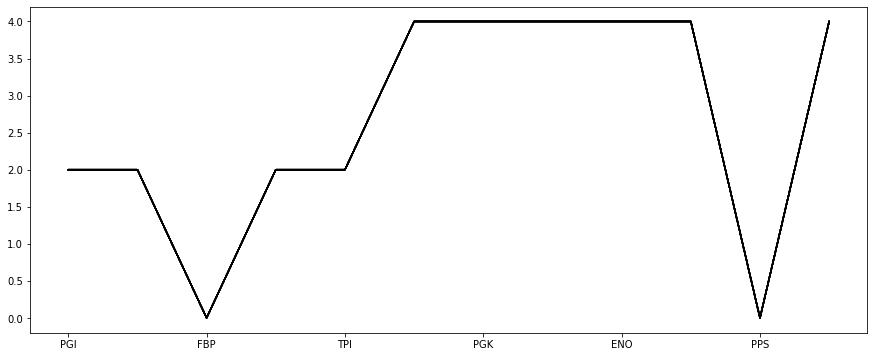

In [10]:
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
velocity_df.abs()[[step.label for step in glycolysis.steps]].T.plot(color='#0001', legend=False, figsize=(15,6))

<AxesSubplot:>

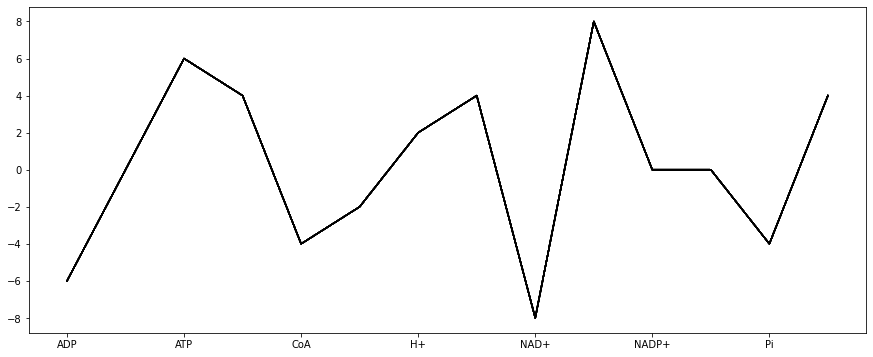

In [11]:
dmdt_df[(sorted(boundary.label for boundary in boundaries))].T.plot(color='#0001', legend=False, figsize=(15,6))

In [12]:
%%time
results = []
for v0s in jax.random.uniform(prng, (100, 21, network.shape[1])):
    v0_ = v0_ = np.median([fba_kinetic.solve(v0=v0).velocities for v0 in v0s], axis=0)
    results.append((fba_kinetic.solve(v0=v0_)))


CPU times: user 5.98 s, sys: 18.4 ms, total: 6 s
Wall time: 6 s


<AxesSubplot:>

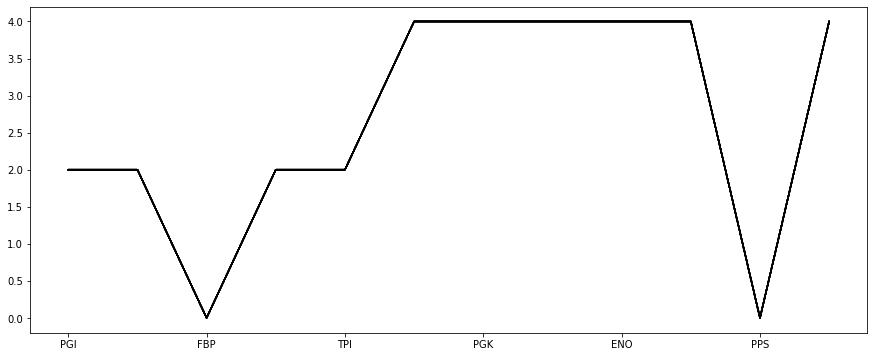

In [13]:
pd.DataFrame([soln.velocities for soln in results], columns=network.reactions.labels()).abs()[[step.label for step in glycolysis.steps]].T.plot(color='#0001', legend=False, figsize=(15,6))

<AxesSubplot:>

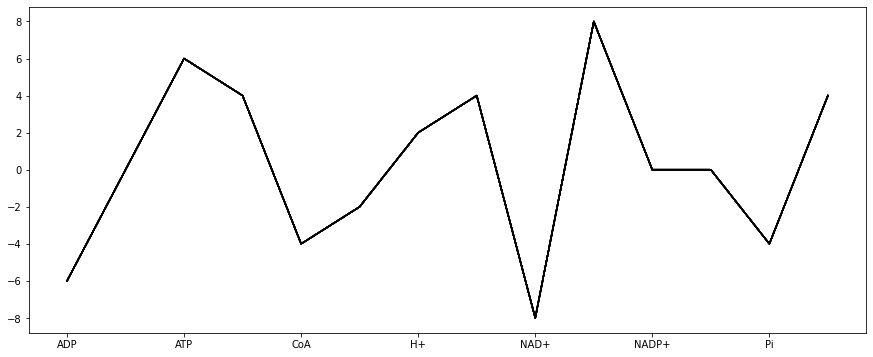

In [14]:
pd.DataFrame([soln.dmdt for soln in results], columns=network.reactants.labels())[sorted(boundary.label for boundary in boundaries)].T.plot(color='#0001', legend=False, figsize=(15,6))